# Elastic Net — Plantilla de experimento

**Cómo usar este cuaderno**
1. Edita la celda **CONFIGURACIÓN** con el nombre del experimento, las Ys y las Xs.
2. Corre todas las celdas en orden (`Run All`).
3. Los resultados se exportan automáticamente al directorio configurado.

Cada paso del pipeline vive en `pipeline/stepXX_*.py` y puede modificarse de forma independiente.

In [1]:
import sys
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
from pathlib import Path

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

# ── Rutas del proyecto ────────────────────────────────────────────────────────
# Sube hasta encontrar paths.yml (funciona desde cualquier subdirectorio)
_here = Path().resolve()
_root = _here
while not (_root / 'paths.yml').exists() and _root.parent != _root:
    _root = _root.parent

with open(_root / 'paths.yml') as f:
    _paths = yaml.safe_load(f)

raw       = Path(_paths['data']['raw'])
temp      = Path(_paths['data']['temp'])
processed = Path(_paths['data']['processed'])
model_out = Path(_paths['outputs']['model'])

# ── Importar pipeline ─────────────────────────────────────────────────────────
# El paquete pipeline/ debe estar en el mismo directorio que este notebook
sys.path.insert(0, str(_here))

from pipeline import (
    load_data,
    analyze_target,
    create_temporal_splits,
    prepare_features,
    impute_missing,
    scale_features,
    tune_hyperparameters,
    optimize_threshold,
    evaluate_model,
    get_coefficients,
    export_results,
)

print('✓ Pipeline importado correctamente')

✓ Pipeline importado correctamente


---
## CONFIGURACIÓN
**Edita esta celda antes de correr el experimento.**

In [2]:
# ─────────────────────────────────────────────────────────────────────────────
# IDENTIFICACIÓN DEL EXPERIMENTO
# ─────────────────────────────────────────────────────────────────────────────
EXPERIMENT_NAME = 'elasticnet_iacv'   # Prefijo de los archivos de salida

# ─────────────────────────────────────────────────────────────────────────────
# RUTAS
# ─────────────────────────────────────────────────────────────────────────────
DATA_PATH   = processed / 'db.parquet'
RESULTS_DIR = model_out   # Carpeta donde se guardan métricas y coeficientes

# ─────────────────────────────────────────────────────────────────────────────
# COLUMNAS CLAVE
# ─────────────────────────────────────────────────────────────────────────────
TARGET_COL       = 'atypical_violence_iacv'  # ← VARIABLE Y
TIME_COL         = 'quarter'            # Formato 'YYYYQN'
MUNICIPALITY_COL = 'mun_code'

# ─────────────────────────────────────────────────────────────────────────────
# SELECCIÓN DE VARIABLES X
#
# OPCIÓN A — Exclusión (se usan todas las columnas EXCEPTO las listadas)
# ─────────────────────────────────────────────────────────────────────────────
#COLS_TO_EXCLUDE = [
#    # Violencia contemporánea (target leakage)
#    'iacv', 'iacv_t', 'qty_iacv',
#    'qty_01', 'qty_02', 'qty_03', 'qty_04', 'qty_05',
#    # Población absoluta
#    'population',
#    # Columna técnica de merge
#    '_merge',
#]
#FEATURE_COLS = None   # Si es None se usa COLS_TO_EXCLUDE

# OPCIÓN B — Selección explícita (descomenta y lista tus Xs)
FEATURE_COLS = [
    'population',
    'dept_code',
    'women_share',
    'petroleo_crudo_median',
    'cafe_arabica_median',
    'oro_median',
    'covid',
    'covid_d',
    'ia_r1',
    'ia_r2',
    'ia_r3',
    'ia_r4',
    'igc_r1',
    'igc_r2',
    'igc_r3',
    'igc_r4',
    'iif_r1',
    'iif_r2',
    'iif_r3',
    'iif_r4',
    'iacv_r1',
    'iacv_r2',
    'iacv_r3',
    'iacv_r4',
    't_01_r1',
    't_01_r2',
    't_01_r3',
    't_01_r4',
    't_02_r1',
    't_02_r2',
    't_02_r3',
    't_02_r4',
    't_03_r1',
    't_03_r2',
    't_03_r3',
    't_03_r4',
    't_04_r1',
    't_04_r2',
    't_04_r3',
    't_04_r4',
    't_05_r1',
    't_05_r2',
    't_05_r3',
    't_05_r4',
    't_07_r1',
    't_07_r2',
    't_07_r3',
    't_07_r4',
    't_08_r1',
    't_08_r2',
    't_08_r3',
    't_08_r4',
    't_09_r1',
    't_09_r2',
    't_09_r3',
    't_09_r4',
    't_10_r1',
    't_10_r2',
    't_10_r3',
    't_10_r4',
    't_11_r1',
    't_11_r2',
    't_11_r3',
    't_11_r4',
    't_12_r1',
    't_12_r2',
    't_12_r3',
    't_12_r4',
    't_13_r1',
    't_13_r2',
    't_13_r3',
    't_13_r4',
    't_14_r1',
    't_14_r2',
    't_14_r3',
    't_14_r4',
    't_15_r1',
    't_15_r2',
    't_15_r3',
    't_15_r4',
    't_16_r1',
    't_16_r2',
    't_16_r3',
    't_16_r4',
    't_17_r1',
    't_17_r2',
    't_17_r3',
    't_17_r4',
    'coca',
    'amapola', 
    'y_corr', 
    'y_corr_tribut_IyC', 
    'DF_ing_func', 
    'DF_deuda',
    'DF_desemp_fisc', 
    's11_total', 
    'docen_total', 
    'alumn_total', 
    'nbi_2005',
    'nbi_2018', 
    'IPM_2005', 
    'IPM_2018',
    'ipm_ledu_p_2005',
    'ipm_ledu_p_2018', 
    'ipm_analf_p_2005', 
    'ipm_analf_p_2018',
    'ipm_asisescu_p_2005', 
    'ipm_asisescu_p_2018', 
    'ipm_rezagoescu_p_2005',
    'ipm_rezagoescu_p_2018', 
    'ipm_serv_pinf_p_2005', 
    'ipm_serv_pinf_p_2018',
    'ipm_ti_p_2005', 
    'ipm_ti_p_2018', 
    'ipm_templeof_p_2005',
    'ipm_templeof_p_2018', 
    'ipm_assalud_p_2005', 
    'ipm_assalud_p_2018',
    'ipm_accsalud_p_2005', 
    'ipm_accsalud_p_2018', 
    'ipm_accagua_p_2005',
    'ipm_accagua_p_2018', 
    'ipm_excretas_p_2005', 
    'ipm_excretas_p_2018',
    'ipm_pisos_p_2005', 
    'ipm_pisos_p_2018', 
    'ipm_paredes_p_2005',
    'ipm_paredes_p_2018', 
    'ipm_hacinam_p_2005', 
    'ipm_hacinam_p_2018',
    'indrural', 
    'areaoficialkm2', 
    'altura', 
    'discapital', 
    'dismdo',
    'disbogota', 
    'distancia_mercado'
]
COLS_TO_EXCLUDE = None   # Se ignora cuando FEATURE_COLS está definida

# ─────────────────────────────────────────────────────────────────────────────
# SPLITS TEMPORALES
# ─────────────────────────────────────────────────────────────────────────────
TRAIN_PROP = 0.70
VAL_PROP   = 0.15
TEST_PROP  = 0.15

# Splits por años específicos (descomenta para usar)
# USE_YEAR_SPLITS   = True
# TRAIN_END_YEAR    = 2018 ; TRAIN_END_QUARTER = 4
# VAL_END_YEAR      = 2020 ; VAL_END_QUARTER   = 4
USE_YEAR_SPLITS = False

# ─────────────────────────────────────────────────────────────────────────────
# HIPERPARÁMETROS
# ─────────────────────────────────────────────────────────────────────────────
PARAM_GRID = {
    'C':        [0.001, 0.01, 0.1, 1, 10, 100],
    'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9],
}
N_CV_SPLITS   = 5
CV_SCORING    = 'f1'          # 'f1' | 'average_precision' | 'roc_auc'
RANDOM_STATE  = 42

# ─────────────────────────────────────────────────────────────────────────────
# THRESHOLD
# ─────────────────────────────────────────────────────────────────────────────
THRESHOLD_RANGE    = (0.1, 0.9)
THRESHOLD_STEP     = 0.05
THRESHOLD_METRIC   = 'f1'     # Métrica a maximizar al elegir el threshold

# ─────────────────────────────────────────────────────────────────────────────
# IMPUTACIÓN
# ─────────────────────────────────────────────────────────────────────────────
NUMERIC_STRATEGY      = 'median'
CATEGORICAL_STRATEGY  = 'most_frequent'

print(f'✓ Configuración lista  |  Experimento: {EXPERIMENT_NAME}')
print(f'  Target  : {TARGET_COL}')
print(f'  X mode  : {"explícita" if FEATURE_COLS else "por exclusión"}')
print(f'  Splits  : {TRAIN_PROP:.0%} / {VAL_PROP:.0%} / {TEST_PROP:.0%}')

✓ Configuración lista  |  Experimento: elasticnet_iacv
  Target  : atypical_violence_iacv
  X mode  : explícita
  Splits  : 70% / 15% / 15%


---
## Paso 1 — Cargar datos

In [3]:
df = load_data(DATA_PATH, time_col=TIME_COL, municipality_col=MUNICIPALITY_COL)
df.head(3)

Cargando datos desde: /Users/juandiegoheredianino/Library/CloudStorage/OneDrive-Universidaddelosandes/early-warning-atypical-violence-forecast/data/processed/db.parquet
✓ Datos cargados: 26,904 filas × 182 columnas
Rango temporal : 2017Q1 → 2022Q4
Periodos únicos: 24 | Municipios: 1121


,mun_code,quarter,population,women_share,petroleo_crudo_mean,petroleo_crudo_median,cafe_arabica_mean,cafe_arabica_median,oro_mean,oro_median,...,areaoficialkm2,altura,discapital,dismdo,disbogota,distancia_mercado,dept_code,año,trimestre,periodo_num
0,05001,2017Q1,2368047.0,0.52995,51.781452,52.690001,144.53629,143.875,1219.658067,1224.150024,...,6075.134367,1475.0,0.000000,0.000000,264.33902,0.000000,05,2017,1,20171
1,05002,2017Q1,20485.0,0.48250,51.781452,52.690001,144.53629,143.875,1219.658067,1224.150024,...,41.315895,2275.0,58.200874,58.200874,209.00545,16.083084,05,2017,1,20171
2,05004,2017Q1,2640.0,0.46364,51.781452,52.690001,144.53629,143.875,1219.658067,1224.150024,...,8.972696,1900.0,63.854633,63.854633,326.94080,49.629030,05,2017,1,20171


---
## Paso 2 — Análisis de la variable objetivo

ANÁLISIS DE VARIABLE OBJETIVO: 'atypical_violence_iacv'
  Clase 1 (positivo): 5,302  (19.71%)
  Clase 0 (negativo): 21,602  (80.29%)
  Desbalance        : 4.07:1


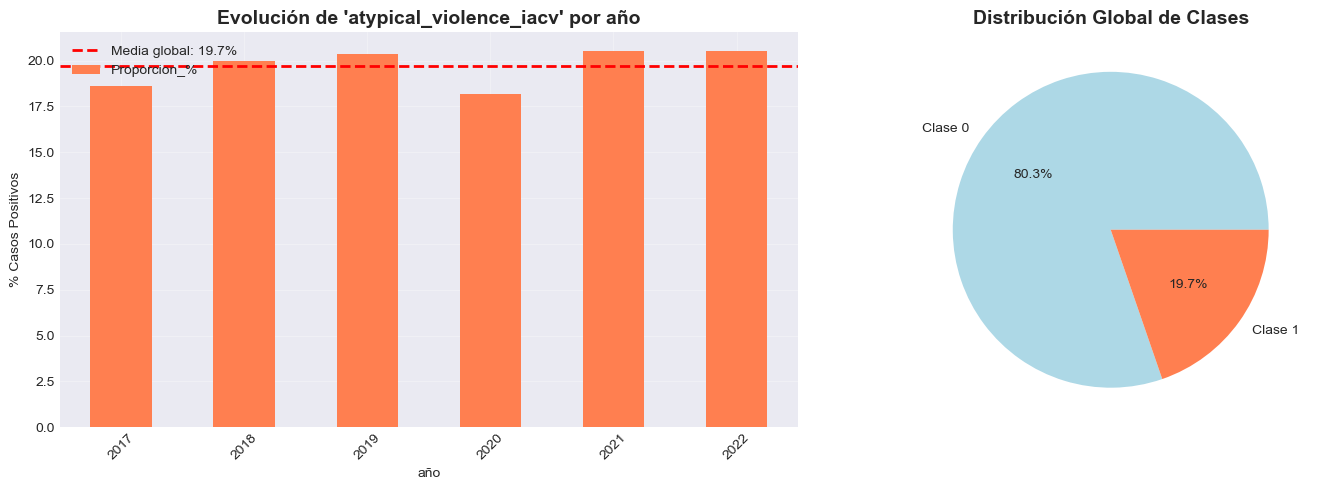

In [4]:
target_stats = analyze_target(df, TARGET_COL, time_group_col='año', plot=True)

---
## Paso 3 — Splits temporales

In [5]:
splits = create_temporal_splits(
    df,
    time_col       = TIME_COL,
    train_prop     = TRAIN_PROP,
    val_prop       = VAL_PROP,
    test_prop      = TEST_PROP,
    use_year_splits = USE_YEAR_SPLITS,
    # Descomenta si USE_YEAR_SPLITS=True:
    # train_end_year=TRAIN_END_YEAR, train_end_quarter=TRAIN_END_QUARTER,
    # val_end_year=VAL_END_YEAR,   val_end_quarter=VAL_END_QUARTER,
)

train_mask = splits['train_mask']
val_mask   = splits['val_mask']
test_mask  = splits['test_mask']

✓ Splits por proporciones (70%/15%/15%):
  Train: 16 periodos  (2017Q1 → 2020Q4)  17,936 obs (66.7%)
  Val  :  4 periodos  (2021Q1 → 2021Q4)  4,484 obs (16.7%)
  Test :  4 periodos  (2022Q1 → 2022Q4)  4,484 obs (16.7%)
✓ Sin overlap


---
## Paso 4 — Preparar features

In [6]:
X, y, feature_cols = prepare_features(
    df,
    target_col       = TARGET_COL,
    municipality_col = MUNICIPALITY_COL,
    time_col         = TIME_COL,
    cols_to_exclude  = COLS_TO_EXCLUDE,
    feature_cols     = FEATURE_COLS,
)

# Aplicar splits
X_train, y_train = X[train_mask].copy(), y[train_mask].copy()
X_val,   y_val   = X[val_mask].copy(),   y[val_mask].copy()
X_test,  y_test  = X[test_mask].copy(),  y[test_mask].copy()

print(f'\nFormas: train={X_train.shape} | val={X_val.shape} | test={X_test.shape}')
for name, yy in [('Train', y_train), ('Val', y_val), ('Test', y_test)]:
    print(f'  {name}: prevalencia={yy.mean():.2%}')

FEATURES DEL MODELO
  Features seleccionadas : 137
  Target                 : 'atypical_violence_iacv'  (prevalencia: 19.71%)

  Variables:
      1. population
      2. dept_code
      3. women_share
      4. petroleo_crudo_median
      5. cafe_arabica_median
      6. oro_median
      7. covid
      8. covid_d
      9. ia_r1
     10. ia_r2
     11. ia_r3
     12. ia_r4
     13. igc_r1
     14. igc_r2
     15. igc_r3
     16. igc_r4
     17. iif_r1
     18. iif_r2
     19. iif_r3
     20. iif_r4
     21. iacv_r1
     22. iacv_r2
     23. iacv_r3
     24. iacv_r4
     25. t_01_r1
     26. t_01_r2
     27. t_01_r3
     28. t_01_r4
     29. t_02_r1
     30. t_02_r2
     31. t_02_r3
     32. t_02_r4
     33. t_03_r1
     34. t_03_r2
     35. t_03_r3
     36. t_03_r4
     37. t_04_r1
     38. t_04_r2
     39. t_04_r3
     40. t_04_r4
     41. t_05_r1
     42. t_05_r2
     43. t_05_r3
     44. t_05_r4
     45. t_07_r1
     46. t_07_r2
     47. t_07_r3
     48. t_07_r4
     49. t_08_r1
     50

---
## Paso 5 — Imputación

In [7]:
X_train, X_val, X_test, imputers = impute_missing(
    X_train, X_val, X_test,
    numeric_strategy     = NUMERIC_STRATEGY,
    categorical_strategy = CATEGORICAL_STRATEGY,
)

Columnas numéricas: 136 | Categóricas: 1
Valores faltantes en train: 0
✓ Sin valores faltantes, no se requiere imputación
NaNs restantes: 0


---
## Paso 6 — Estandarización

In [8]:
X_train_sc, X_val_sc, X_test_sc, scaler = scale_features(
    X_train, X_val, X_test, feature_cols
)

✓ Estandarización sin leakage
  Verificación train → Media ~0: 1.39e-15 | Std ~1: 2.79e-05


In [9]:
X_train

,population,dept_code,women_share,petroleo_crudo_median,cafe_arabica_median,oro_median,covid,covid_d,ia_r1,ia_r2,...,ipm_paredes_p_2018,ipm_hacinam_p_2005,ipm_hacinam_p_2018,indrural,areaoficialkm2,altura,discapital,dismdo,disbogota,distancia_mercado
0,2368047.0,05,0.52995,52.690001,143.875000,1224.150024,0.0,0.0,0.0,0.0,...,0.7,11.78000,5.4,0.011679,6075.134367,1475.0,0.000000,0.000000,264.33902,0.000000
1,20485.0,05,0.48250,52.690001,143.875000,1224.150024,0.0,0.0,0.0,0.0,...,0.3,14.33649,5.2,0.649700,41.315895,2275.0,58.200874,58.200874,209.00545,16.083084
2,2640.0,05,0.46364,52.690001,143.875000,1224.150024,0.0,0.0,0.0,0.0,...,0.8,15.02591,5.4,0.644337,8.972696,1900.0,63.854633,63.854633,326.94080,49.629030
3,4610.0,05,0.49935,52.690001,143.875000,1224.150024,0.0,0.0,0.0,0.0,...,0.4,15.31100,4.1,0.473654,30.596026,1750.0,61.114216,61.114216,241.82600,15.529276
4,29528.0,05,0.50836,52.690001,143.875000,1224.150024,0.0,0.0,0.0,0.0,...,0.3,11.34089,4.8,0.429862,345.811765,1400.0,29.878857,29.878857,247.85628,24.321695
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17931,1086.0,97,0.45028,41.440001,112.350002,1879.799988,15.0,0.0,0.0,0.0,...,2.2,49.51456,37.6,1.000000,0.219535,100.0,95.496735,569.509770,650.81870,569.509770
17932,22205.0,99,0.46692,41.440001,112.350002,1879.799988,238.0,5.0,0.0,0.0,...,20.7,35.55772,24.8,0.226520,1.675477,51.0,0.000000,545.198800,673.75850,516.201400
17933,10365.0,99,0.46261,41.440001,112.350002,1879.799988,27.0,2.0,0.0,0.0,...,12.3,30.58934,19.8,0.375937,0.500670,100.0,116.604330,475.813260,558.27405,408.026180
17934,4143.0,99,0.48250,41.440001,112.350002,1879.799988,4.0,0.0,0.0,0.0,...,10.3,51.02740,19.4,0.369664,2.003717,125.0,282.585200,326.586200,394.52734,265.077270


---
## Paso 7 — Búsqueda de hiperparámetros

In [10]:
import pandas as pd

X_tv = pd.concat([X_train_sc, X_val_sc])
y_tv = pd.concat([y_train, y_val])

best_model, cv_results = tune_hyperparameters(
    X_tv, y_tv,
    param_grid   = PARAM_GRID,
    n_cv_splits  = N_CV_SPLITS,
    scoring      = CV_SCORING,
    random_state = RANDOM_STATE,
)

GridSearchCV: 30 combinaciones × 5 folds | métrica: f1
Fitting 5 folds for each of 30 candidates, totalling 150 fits

✓ Mejores hiperparámetros:
  C: 0.01
  l1_ratio: 0.7
  Mejor f1 (CV): 0.3637

Top 5 configuraciones:
 param_C  param_l1_ratio  mean_test_score  std_test_score
    0.01             0.7         0.363707        0.012287
    0.01             0.9         0.363274        0.013575
    0.01             0.5         0.362646        0.011164
    0.01             0.3         0.360941        0.012875
    0.01             0.1         0.359444        0.010400


---
## Paso 8 — Optimización de threshold

Threshold óptimo (f1): 0.50
  F1: 0.3917 | Precision: 0.2615 | Recall: 0.7804


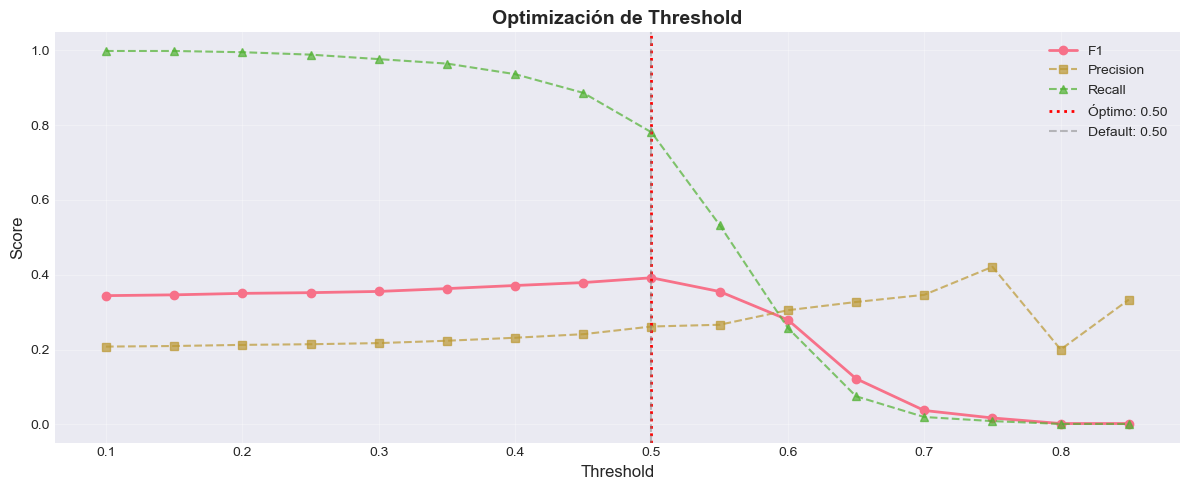

In [11]:
best_threshold, threshold_df = optimize_threshold(
    best_model, X_val_sc, y_val,
    threshold_range  = THRESHOLD_RANGE,
    threshold_step   = THRESHOLD_STEP,
    optimize_metric  = THRESHOLD_METRIC,
    plot             = True,
)

---
## Paso 9 — Evaluación en test

EVALUACIÓN FINAL EN TEST SET
  AUPRC                 : 0.3017
  AUROC                 : 0.6546
  Balanced_Accuracy     : 0.6004
  F1_Score              : 0.3892
  Precision             : 0.2535
  Recall                : 0.8370
  Cohen_Kappa           : 0.1084
  Threshold             : 0.5000

Classification Report:
              precision    recall  f1-score   support

     Clase 0     0.8963    0.3639    0.5177      3564
     Clase 1     0.2535    0.8370    0.3892       920

    accuracy                         0.4610      4484
   macro avg     0.5749    0.6004    0.4534      4484
weighted avg     0.7645    0.4610    0.4913      4484



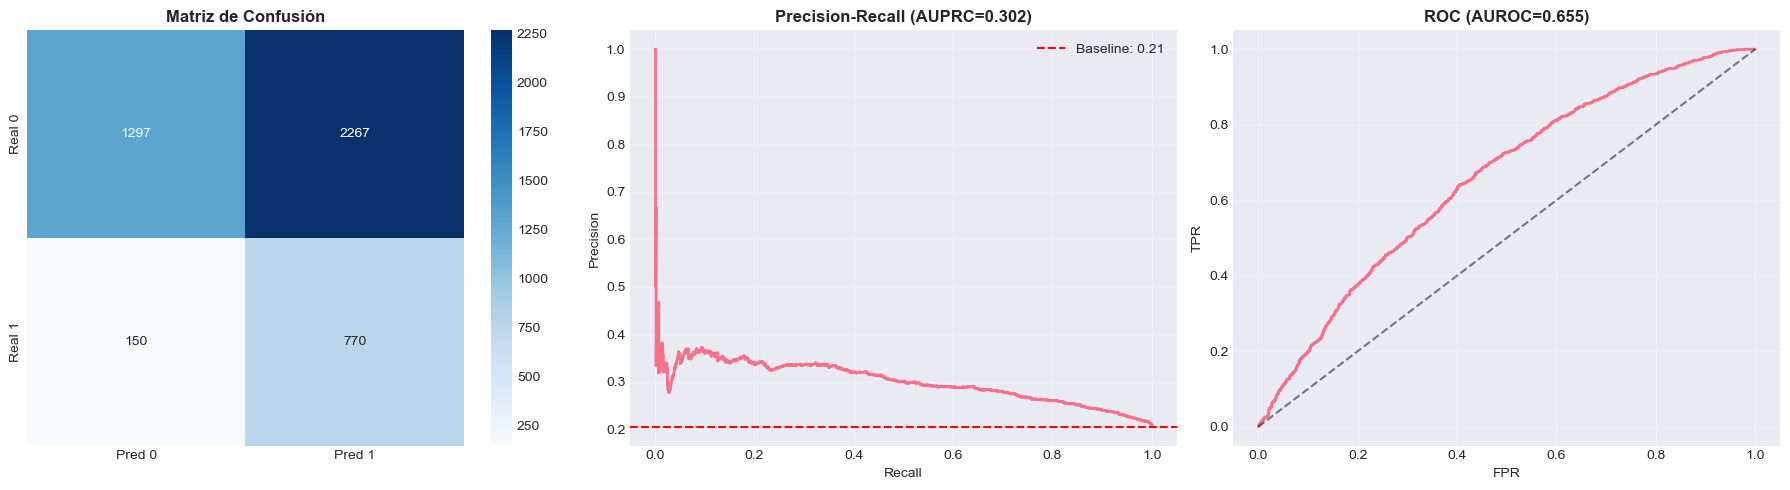

In [12]:
metrics, y_test_proba, y_test_pred = evaluate_model(
    best_model, X_test_sc, y_test,
    threshold = best_threshold,
    plot      = True,
)

---
## Paso 10 — Interpretabilidad

INTERPRETABILIDAD — COEFICIENTES
  Features activas    : 79 de 137
  Eliminadas (coef=0) : 58
  → ['ipm_analf_p_2018', 'ipm_asisescu_p_2018', 'nbi_2005', 'disbogota', 'nbi_2018', 'IPM_2005', 'ipm_accagua_p_2005', 'IPM_2018', 'ipm_ledu_p_2005', 'ipm_assalud_p_2018', 'ipm_templeof_p_2005', 'ipm_ledu_p_2018', 'ipm_analf_p_2005', 'ipm_excretas_p_2018', 'ipm_pisos_p_2018', 'ipm_accsalud_p_2018', 'discapital', 'ipm_serv_pinf_p_2005', 't_13_r1', 's11_total', 't_01_r2', 't_04_r3', 't_03_r3', 't_03_r2', 't_02_r4', 't_02_r3', 't_02_r2', 't_02_r1', 'iif_r3', 't_08_r2', 'iif_r1', 'igc_r4', 'igc_r3', 'igc_r1', 'ia_r3', 'covid', 'women_share', 't_07_r1', 't_08_r3', 'DF_deuda', 't_15_r2', 'DF_ing_func', 'y_corr', 'amapola', 't_17_r3', 't_17_r2', 't_15_r4', 't_15_r3', 't_15_r1', 't_08_r4', 't_14_r3', 't_13_r4', 't_12_r1', 't_11_r3', 't_10_r3', 't_09_r2', 't_09_r1', 'distancia_mercado']

Top 20 por magnitud:
              Feature  Coeficiente  Odds_Ratio
       DF_desemp_fisc    -0.222389    0.800604
 

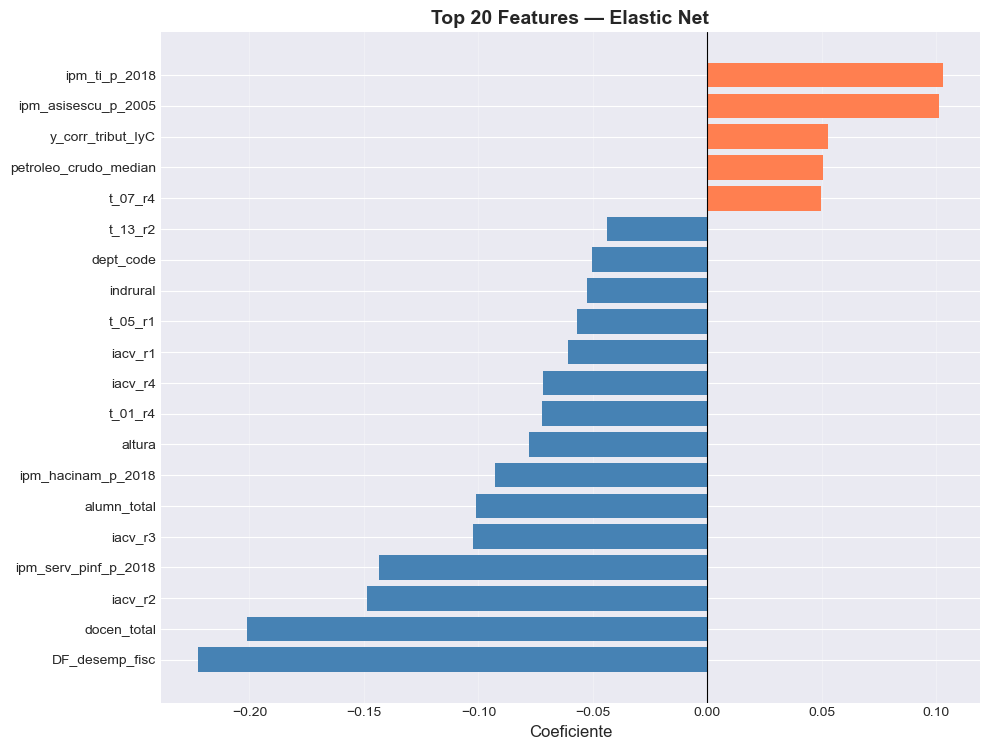

In [13]:
coeficientes = get_coefficients(best_model, feature_cols, top_n=20, plot=True)

---
## Paso 11 — Exportar resultados

In [14]:
extra = {
    'n_features':      len(feature_cols),
    'train_size':      len(y_train),
    'val_size':        len(y_val),
    'test_size':       len(y_test),
    'train_prev':      float(y_train.mean()),
    'val_prev':        float(y_val.mean()),
    'test_prev':       float(y_test.mean()),
    'best_C':          best_model.C,
    'best_l1_ratio':   best_model.l1_ratio,
    'cv_scoring':      CV_SCORING,
    'target_col':      TARGET_COL,
}

output_paths = export_results(
    results_dir     = RESULTS_DIR,
    experiment_name = EXPERIMENT_NAME,
    metrics         = metrics,
    coeficientes    = coeficientes,
    extra_info      = extra,
)

✓ Resultados exportados en: /Users/juandiegoheredianino/Library/CloudStorage/OneDrive-Universidaddelosandes/early-warning-atypical-violence-forecast/outputs/model
  Métricas     : elasticnet_iacv_metrics_20260219_061231.csv
  Coeficientes : elasticnet_iacv_coeficientes_20260219_061231.csv
